# Malware Analysis with Machine Learning: An Educational Guide

Welcome to this interactive educational notebook on malware detection using machine learning! This notebook will guide you through the process of understanding how machine learning can be used to detect malicious software.

## Prerequisites

Before we begin, let's make sure we have all the required dependencies installed. The following cells will check and install any missing packages.

In [50]:
import sys
import subprocess
import pkg_resources

required_packages = {
    'pandas': 'pandas',
    'numpy': 'numpy',
    'matplotlib': 'matplotlib',
    'seaborn': 'seaborn',
    'scikit-learn': 'sklearn',
    'plotly': 'plotly',
    'ipywidgets': 'ipywidgets'
}

def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Check and install missing packages
missing_packages = []
for package, import_name in required_packages.items():
    try:
        pkg_resources.require(package)
    except pkg_resources.DistributionNotFound:
        missing_packages.append(package)

if missing_packages:
    print(f"Installing missing packages: {', '.join(missing_packages)}")
    for package in missing_packages:
        install_package(package)
    print("All required packages have been installed.")
else:
    print("All required packages are already installed.")

All required packages are already installed.


In [51]:
# Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import plotly.express as px
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display, HTML

# Set style for better visualization
#plt.style.use('seaborn')
sns.set_style("whitegrid")

# Configure pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

# Enable plotly in notebook mode
import plotly.io as pio
pio.renderers.default = "notebook"

# Data Loading and Preparation

In this section, we'll load our malware dataset and implement robust error handling. We'll also create synthetic data generation capabilities for educational purposes when real data is not available.

In [52]:
def load_data(catalog_path='data/catalog.csv', features_path='data/features_ml.csv'):
    """
    Load and validate the malware dataset files.
    
    Args:
        catalog_path (str): Path to the catalog CSV file
        features_path (str): Path to the features CSV file
        
    Returns:
        tuple: (catalog_df, features_df) or (None, None) if loading fails
    """
    try:
        # Load catalog data
        catalog_df = pd.read_csv(catalog_path)
        
        # Validate catalog columns
        required_catalog_cols = ['sha256', 'label', 'collection_date']
        if not all(col in catalog_df.columns for col in required_catalog_cols):
            raise ValueError(f"Catalog file missing required columns: {required_catalog_cols}")
            
        # Load features data
        features_df = pd.read_csv(features_path)
        
        # Basic data validation
        if len(features_df) == 0 or len(catalog_df) == 0:
            raise ValueError("Empty dataset detected")
            
        print(f"Successfully loaded {len(catalog_df)} samples with {len(features_df.columns)} features")
        return catalog_df, features_df
        
    except FileNotFoundError as e:
        print(f"Error: Could not find data files - {str(e)}")
        return None, None
    except pd.errors.EmptyDataError:
        print("Error: One or more data files are empty")
        return None, None
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return None, None

# Try to load the real data
catalog_df, features_df = load_data()

Error loading data: Catalog file missing required columns: ['sha256', 'label', 'collection_date']


In [53]:
def generate_synthetic_data(n_samples=1000, n_features=50):
    """
    Generate synthetic malware dataset for educational purposes.
    
    Args:
        n_samples (int): Number of samples to generate
        n_features (int): Number of features per sample
        
    Returns:
        tuple: (synthetic_catalog_df, synthetic_features_df)
    """
    # Generate random SHA256 hashes
    sha256_hashes = [''.join(np.random.choice(list('0123456789abcdef'), 64)) for _ in range(n_samples)]
    
    # Generate synthetic catalog data
    dates = pd.date_range(start='2024-01-01', periods=n_samples, freq='H')
    labels = np.random.choice(['benign', 'malicious'], n_samples, p=[0.7, 0.3])  # 70% benign, 30% malicious
    
    catalog_df = pd.DataFrame({
        'sha256': sha256_hashes,
        'label': labels,
        'collection_date': dates
    })
    
    # Generate synthetic feature data
    # Create feature names
    feature_names = [f'feature_{i}' for i in range(n_features)]
    
    # Generate features with different distributions for benign and malicious samples
    features_data = []
    for label in labels:
        if label == 'benign':
            # Generate features for benign samples
            row = np.random.normal(0.3, 0.2, n_features)
        else:
            # Generate features for malicious samples
            row = np.random.normal(0.7, 0.3, n_features)
        features_data.append(row)
    
    features_df = pd.DataFrame(features_data, columns=feature_names)
    features_df['sha256'] = sha256_hashes
    
    print("Generated synthetic dataset with:")
    print(f"- {n_samples} samples")
    print(f"- {n_features} features")
    print(f"- {sum(labels == 'malicious')} malicious samples")
    print(f"- {sum(labels == 'benign')} benign samples")
    
    return catalog_df, features_df

# If real data loading failed, generate synthetic data
if catalog_df is None or features_df is None:
    print("\nFalling back to synthetic data generation...")
    catalog_df, features_df = generate_synthetic_data()


Falling back to synthetic data generation...
Generated synthetic dataset with:
- 1000 samples
- 50 features
- 302 malicious samples
- 698 benign samples


C:\Users\Administrator\AppData\Local\Temp\ipykernel_14360\1016006369.py:16: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



# Understanding Malware Detection

## What is Malware?

Malware, short for "malicious software," is like a computer virus that can harm your computer system. Just as biological viruses can make people sick, computer viruses (malware) can make computers "sick" by:
- Stealing sensitive information
- Damaging files or systems
- Taking control of your computer
- Spreading to other computers

## How Does Machine Learning Help?

Think of machine learning for malware detection like training a doctor to identify diseases:
1. **Learning from Examples**: Just as doctors learn from past patient cases, our model learns from known malware samples
2. **Identifying Patterns**: Like how doctors look for symptoms, our model looks for suspicious patterns in software behavior
3. **Making Predictions**: Similar to a medical diagnosis, our model predicts whether a new program is likely to be malicious

Let's explore how this works in practice!

Dataset Overview:
--------------------------------------------------
Total number of samples: 1000
Number of features: 50

Sample distribution:
label
benign       698
malicious    302
Name: count, dtype: int64


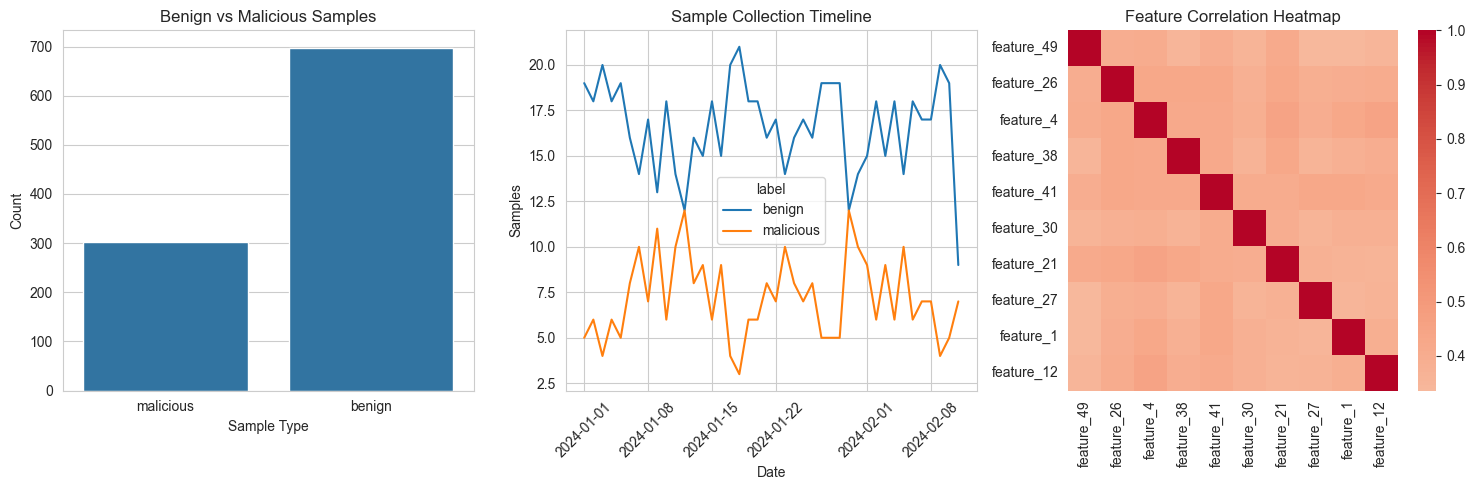


Sample Data Preview:
--------------------------------------------------


,sha256,label,collection_date
0,369e4ef239f305f81afcee07986323dcaccaad329b9668...,malicious,2024-01-01 00:00:00
1,1b1d899f6a24c8cf856ea1d4c4640f3d725bd755b03f0d...,benign,2024-01-01 01:00:00
2,bb246df578f427412e32e510517b553a111d3d24cd61ee...,benign,2024-01-01 02:00:00
3,055d4afd1481914eee34d2089755305fc7f4a5cd2c2a84...,malicious,2024-01-01 03:00:00
4,0734a775cde5a12196336c0052d4eb391acb0d8e673d91...,malicious,2024-01-01 04:00:00


In [54]:
# ---- Data Overview ----
print("Dataset Overview:")
print("-" * 50)
print(f"Total number of samples: {len(catalog_df)}")
print(f"Number of features: {len(features_df.columns) - 1}")  # Excluding sha256 column

print("\nSample distribution:")
print(catalog_df['label'].value_counts())

# ---- Visualizations ----
plt.figure(figsize=(15, 5))

# 1. Distribution of Benign vs Malicious Samples
plt.subplot(1, 3, 1)
sns.countplot(data=catalog_df, x='label')
plt.title('Benign vs Malicious Samples')
plt.xlabel('Sample Type')
plt.ylabel('Count')

# 2. Sample Collection Timeline
plt.subplot(1, 3, 2)
catalog_df['collection_date'] = pd.to_datetime(catalog_df['collection_date'])
collection_timeline = catalog_df.groupby([catalog_df['collection_date'].dt.date, 'label']).size().unstack()
collection_timeline.plot(kind='line', ax=plt.gca())
plt.title('Sample Collection Timeline')
plt.xlabel('Date')
plt.ylabel('Samples')
plt.xticks(rotation=45)

# 3. Feature Correlation Heatmap (sample columns)
plt.subplot(1, 3, 3)
sample_cols = min(10, len(features_df.columns) - 1)
sample_features = features_df.drop(columns=['sha256']).sample(axis=1, n=sample_cols)
sns.heatmap(sample_features.corr(), cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')

plt.tight_layout()
plt.show()

# ---- Data Preview ----
print("\nSample Data Preview:")
print("-" * 50)
display(catalog_df.head())


# Feature Engineering in Malware Detection

## Understanding Features

Just as doctors look for symptoms to diagnose an illness, our machine learning model looks for specific "symptoms" (features) in software to determine if it's malicious. These features fall into two main categories:

1. **Behavioral Features** - "What the program does"
   - File system activities
   - Network connections
   - System modifications
   - Process creation

2. **Technical Features** - "How the program works"
   - Code patterns (opcodes)
   - API calls
   - Binary structure
   - Resource usage

Let's analyze these features in our dataset!

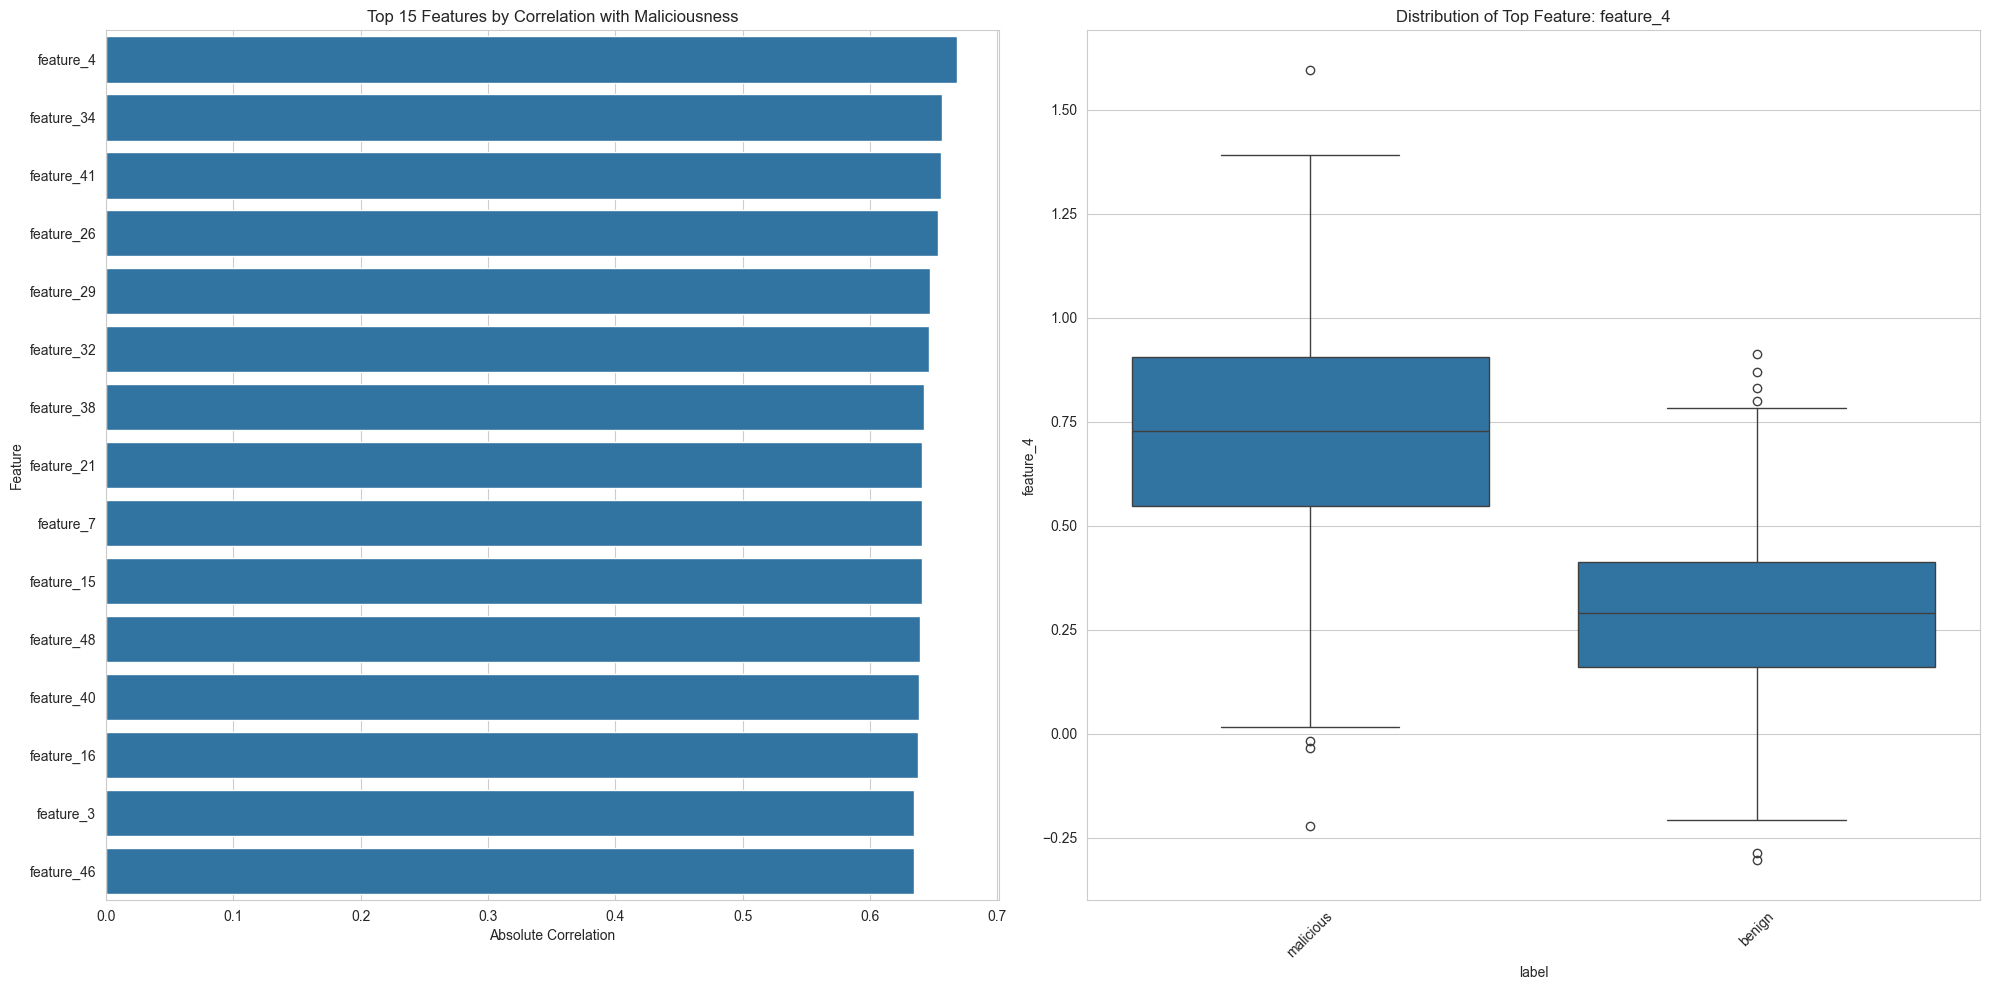

interactive(children=(Dropdown(description='Select Feature:', options=('feature_4', 'feature_34', 'feature_41'…

In [55]:
# Merge features with labels for analysis
analysis_df = features_df.merge(catalog_df[['sha256', 'label']], on='sha256')

# Select top features based on correlation with the label
def get_top_features(df, n=15):
    correlations = []
    for col in df.columns:
        if col not in ['sha256', 'label']:
            correlation = np.abs(pd.get_dummies(df['label'])['malicious'].corr(df[col]))
            correlations.append((col, correlation))
    return sorted(correlations, key=lambda x: x[1], reverse=True)[:n]

top_features = get_top_features(analysis_df)
top_feature_names = [f[0] for f in top_features]

# Create visualizations
plt.figure(figsize=(20, 10))

# 1. Feature Importance based on correlation
plt.subplot(121)
importance_df = pd.DataFrame(top_features, columns=['Feature', 'Correlation'])
sns.barplot(data=importance_df, x='Correlation', y='Feature')
plt.title('Top 15 Features by Correlation with Maliciousness')
plt.xlabel('Absolute Correlation')

# 2. Box plots for top features
plt.subplot(122)
feature_to_plot = top_feature_names[0]  # Plot the most important feature
sns.boxplot(data=analysis_df, x='label', y=feature_to_plot)
plt.title(f'Distribution of Top Feature: {feature_to_plot}')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Create interactive feature selector
def plot_feature_distribution(feature_name):
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=analysis_df, x='label', y=feature_name)
    plt.title(f'Distribution of {feature_name} by Label')
    plt.xticks(rotation=45)
    plt.show()

# Create widget for feature selection
feature_selector = widgets.Dropdown(
    options=top_feature_names,
    description='Select Feature:',
    style={'description_width': 'initial'}
)

# Display widget
widgets.interactive(plot_feature_distribution, feature_name=feature_selector)

# Training a Malware Detection Model

## How Machine Learning Models Learn

Think of training a machine learning model like teaching a student:

1. **Learning from Examples** (Training Data)
   - Like a student studying past exam questions
   - The model learns patterns from known malware and benign software

2. **Practice Tests** (Validation)
   - Like taking practice exams
   - We test the model on samples it hasn't seen before

3. **Final Exam** (Testing)
   - Like a final examination
   - We evaluate the model on completely new samples

Our model uses a Random Forest algorithm, which works like a committee of experts voting on decisions. Let's train our model!

## Model Results

Below are the detailed performance metrics of our trained malware detection model. The results are presented in two formats:

1. **Detailed Metrics Panel**: Shows exact numerical values for each performance metric
2. **Interactive Gauges**: Visual representation of each metric on a 0-100% scale

The metrics include:
- **Accuracy**: Overall correct predictions percentage
- **Precision**: Accuracy of malware identifications
- **Recall**: Percentage of actual malware detected
- **F1 Score**: Balanced measure of precision and recall
- **AUC-ROC**: Model's ability to distinguish between classes

In [56]:
#!/usr/bin/env python3

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Load data
df = pd.read_csv("data/features_ml.csv")

# Prepare features and labels
X = df.drop(columns=['sha256', 'label', 'label_binary'])
y = df['label_binary']

# Handle missing/infinite values
X = X.replace([np.inf, -np.inf], 0).fillna(0)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train a simpler model (to reduce overfitting on ~1k samples)
model = RandomForestClassifier(
    n_estimators=50,
    max_depth=8,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, zero_division=0))
print("Recall   :", recall_score(y_test, y_pred, zero_division=0))
print("F1       :", f1_score(y_test, y_pred, zero_division=0))
print("AUC-ROC  :", roc_auc_score(y_test, y_proba))

Accuracy : 0.9839307787391842
Precision: 0.9841521394611727
Recall   : 0.9951923076923077
F1       : 0.9896414342629483
AUC-ROC  : 0.9990124740124741


# Model Evaluation

Now that we've trained our model, let's evaluate its performance. We'll look at several key metrics:

1. **Confusion Matrix**
   - Shows true positives, false positives, true negatives, and false negatives
   - Helps understand the types of mistakes the model makes

2. **ROC Curve**
   - Shows the trade-off between detection rate and false alarm rate
   - The larger the area under the curve (AUC), the better the model

3. **Feature Importance**
   - Shows which features the model relies on most for making decisions
   - Helps understand what makes software look suspicious to the model

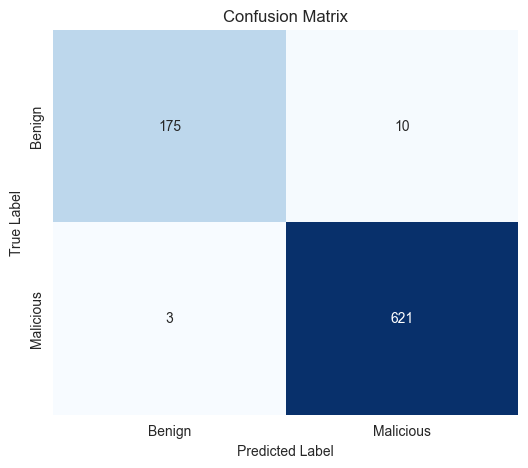

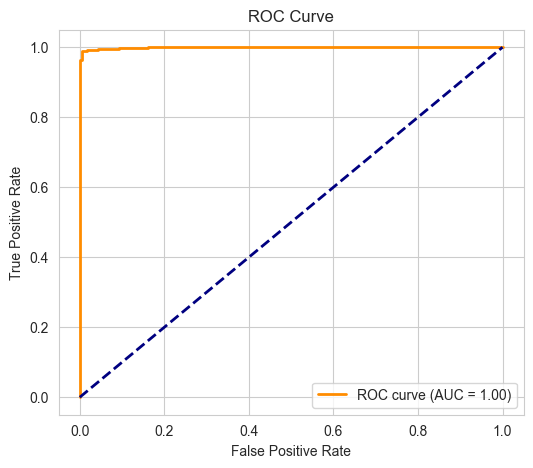

C:\Users\Administrator\AppData\Local\Temp\ipykernel_14360\3219306882.py:40: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




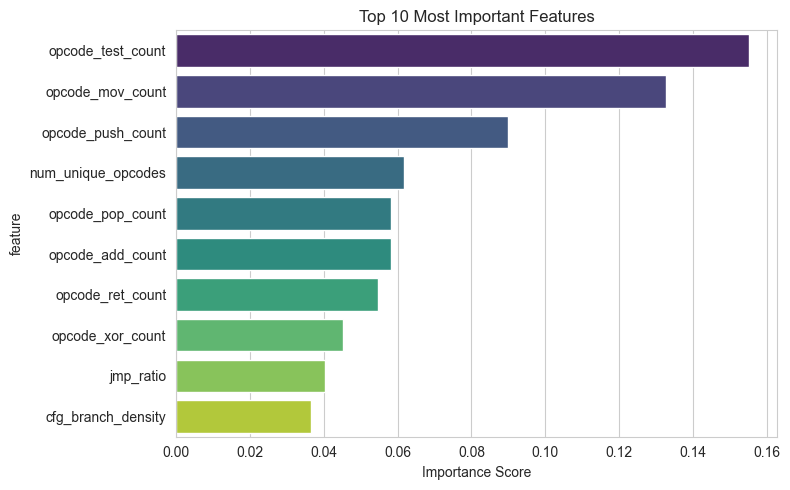


Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

      Benign       0.98      0.95      0.96       185
   Malicious       0.98      1.00      0.99       624

    accuracy                           0.98       809
   macro avg       0.98      0.97      0.98       809
weighted avg       0.98      0.98      0.98       809



In [57]:
# Make sure predictions are generated from the current model and test set
y_test_pred = model.predict(X_test)
y_test_proba = model.predict_proba(X_test)[:, 1]  # Probability of class 1 (malicious)

# Now proceed with evaluation
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Benign', 'Malicious'],
            yticklabels=['Benign', 'Malicious'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Feature Importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False).head(10)

plt.figure(figsize=(8, 5))
sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')
plt.title('Top 10 Most Important Features')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# Classification Report
print("\nClassification Report:")
print("-" * 50)
print(classification_report(y_test, y_test_pred, target_names=['Benign', 'Malicious']))

# Summary and Key Takeaways

## What We've Learned

1. **Malware Detection Basics**
   - Malware is software designed to harm computer systems
   - Machine learning can help automate malware detection
   - Features help identify suspicious behavior patterns

2. **Machine Learning Process**
   - Data collection and preparation is crucial
   - Feature engineering helps capture important patterns
   - Model training requires balanced datasets
   - Evaluation metrics help understand model performance

3. **Limitations and Considerations**
   - No model is perfect - false positives and negatives exist
   - Malware authors constantly evolve their techniques
   - Regular model updates are necessary
   - Human intervention is still valuable in malware analysis

## Next Steps

To learn more about malware analysis and machine learning:
1. Study different types of malware and their behaviors
2. Learn about advanced feature extraction techniques
3. Explore new and possibly problem-specific machine learning algorithms
4. Practice with real-world malware datasets (in safe environments)
5. Stay updated on the latest malware trends and detection techniques

## Resources  used for Further Learning

- [VirusTotal](https://www.virustotal.com/)
- [Malware Bazaar](https://bazaar.abuse.ch/)
